In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
import shap
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


/Users/nick/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv("../processing/merged_data.csv", index_col=[0])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,componentindex_249.0,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp
1.0,0,1,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
2.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
3.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
5.0,0,1,1,1,0,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,1


In [8]:
def crossval(features, target, nfolds=5, nruns=100):
    
    np.random.seed(0)
    foldseeds = np.random.randint(10*nruns,size=nruns)
    
    params = {'objective': 'binary', 'metric': 'auc', 'random_state': 0}
    
    norm = nfolds*nruns
    
    feat_vals = features.values
    
    if len(feat_vals.shape)==1:
        feat_vals = np.reshape(feat_vals, (-1,1))
    
    shap_values = np.zeros((feat_vals.shape[0],feat_vals.shape[1]+1))
    
    aucs = []
    accs = []
    
    for run in range(nruns):
        
        CV = KFold(n_splits=nfolds, shuffle=True, random_state=foldseeds[run])
        
        auc = 0.
        acc = 0.

        for train_index, test_index in CV.split(feat_vals):
    
            X_tr, X_tst = feat_vals[train_index], feat_vals[test_index]
            y_tr, y_tst = target.iloc[train_index], target.iloc[test_index]
    
            train_set = lgb.Dataset(X_tr, label=y_tr)
            valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
            bst = lgb.train(params, train_set, num_boost_round=250, valid_sets=[train_set, valid_set],
                            early_stopping_rounds=50, verbose_eval=False)
    
            probs = bst.predict(X_tst, num_iteration=bst.best_iteration)
            classes = np.heaviside(probs - 0.5, 1).astype(int)
    
            auc += roc_auc_score(y_tst, probs)/nfolds
            acc += accuracy_score(y_tst, classes)/nfolds
    
            explainer = shap.TreeExplainer(bst)
            shap_values = explainer.shap_values(data2)
        
        aucs.append(auc)
        accs.append(acc)
        
    aucs = np.array(aucs)
    accs = np.array(accs)
    
    return aucs, accs, shap_values

In [9]:
target = data.infection_status
data2 = data.drop(['infection_status'], axis=1)
data2.head()

,0,1,2,3,4,5,6,7,8,9,...,componentindex_246.0,componentindex_249.0,componentindex_251.0,time_point,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp
1.0,0,1,0,1,0,0,0,1,1,0,...,1,0,1,0,1,0,0,0,0,1
2.0,0,1,1,1,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,1
3.0,0,1,1,1,0,0,0,1,1,0,...,0,0,1,0,0,1,0,0,0,1
4.0,0,1,1,1,0,0,0,1,1,0,...,1,0,1,0,1,0,0,0,0,1
5.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,0,0,0,1,0,0,1


In [10]:
aucs, accs, shaps = crossval(data2, target)

In [11]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.988249
std AUC: 0.005585
mean accuracy: 0.918497
std accuracy: 0.016100


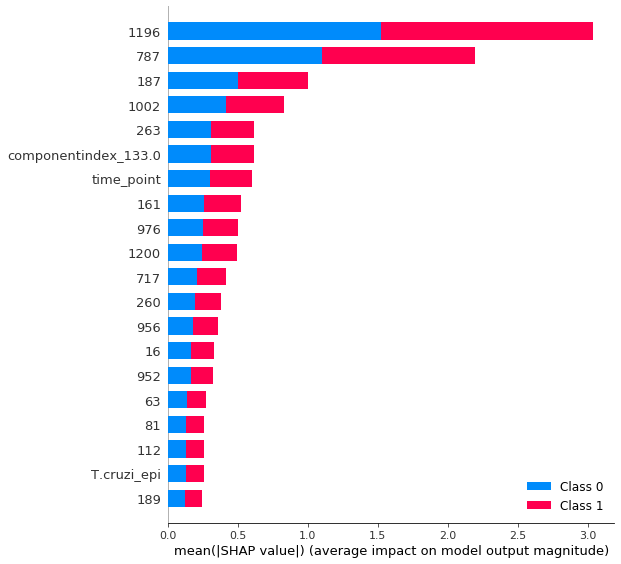

In [13]:
shap.summary_plot(shaps, data2, max_display=20)